# Similarity analysis of mapped pathways

This notebook shows explores the similarity of the pathways mapped across KEGG, Reactome, and WikiPathways. For that, we look at the overlap of genes between the curated mappings. Similarity is calculated using the [Szymkiewicz–Simpson coefficient](https://en.wikipedia.org/wiki/Overlap_coefficient).

Author: [Daniel Domingo-Fernández](https://github.com/ddomingof)

In [1]:
import pandas as pd
import numpy as np

from bio2bel_kegg.manager import Manager as KeggManager
from bio2bel_wikipathways.manager import Manager as WikiPathwaysManager
from bio2bel_reactome.manager import Manager as ReactomeManager

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

Load Established Mappings

In [3]:
kegg_wikipathways_df = pd.read_excel(
    'https://github.com/ComPath/curation/raw/master/mappings/kegg_wikipathways.xlsx',
    index_col=0
)
kegg_reactome_df = pd.read_excel(
    'https://github.com/ComPath/curation/raw/master/mappings/kegg_reactome.xlsx',
    index_col=0
)
wikipathways_reactome_df = pd.read_excel(
    'https://github.com/ComPath/curation/raw/master/mappings/wikipathways_reactome.xlsx',
    index_col=0
)

Call the Database Managers to query gene sets

In [4]:
kegg_manager = KeggManager()
wikipathways_manager = WikiPathwaysManager()
reactome_manager = ReactomeManager()

Methods to calculate similarity and process mappings

In [5]:
def calculate_szymkiewicz_simpson_coefficient(set_1, set_2):
    """Calculate Szymkiewicz-Simpson coefficient between two sets.
    
    :param set set_1: set 1
    :param set set_2: set 2
    :returns similarity
    :rtype: float
    """
    
    intersection = len(set_1.intersection(set_2))
    smaller_set = min(len(set_1), len(set_2))
        
    return intersection/smaller_set

def get_gene_set_from_pathway_model(pathway_model):
    """Return the gene set given a Bio2BEL ComPath Pathway model.
    
    :rtype: set
    """
    return  {
        gene.hgnc_symbol
        for gene in pathway_model.proteins
    }

def get_pathway_models(reference_manager, compared_manager, pathway_1_name, pathway_2_name):
    """Return the pathway models from their correspondent managers.
    
    :rtype: tuple(Pathway, Pathway)
    """
    pathway_1 = reference_manager.get_pathway_by_name(pathway_1_name)
    
    pathway_2 = compared_manager.get_pathway_by_name(pathway_2_name)
    
    if pathway_1 is None:
        raise ValueError("Not Valid Pathway Name: {}".format(pathway_1_name))
        
    if pathway_2 is None:
        raise ValueError("Not Valid Pathway Name: {}".format(pathway_2_name))
        
    return pathway_1, pathway_2
   
def get_overlap(reference_manager, compared_manager, reference_pathway_name, compared_pathway_name):
    """Calculate the overlap between two pathways"""
        
    pathway_1, pathway_2 = get_pathway_models(reference_manager, compared_manager, reference_pathway_name, compared_pathway_name)
    
    return calculate_szymkiewicz_simpson_coefficient(get_gene_set_from_pathway_model(pathway_1), get_gene_set_from_pathway_model(pathway_2))
   
def get_pathways_from_statement(mapping_statement, mapping_type):
    """Return the subject, object of the mapping.
    
    :param str mapping_statement: statement
    :param str mapping_type: type of relationship
    :rtype: tuple[str,str]
    """
    _pathways = mapping_statement.split(mapping_type)
        
    return _pathways[0].strip(), _pathways[1].strip()


def remove_star_from_pathway_name(pathway_name):
    """Remove the star that label the reference pathway in isPartOf statements.
    
    :param str statements: pathway name
    """
    return pathway_name.replace("*", "").strip()

    
def get_pathways_from_is_part_of_mapping(mapping_statement):
    """Return the pathways of a hierarchical mapping."""

    pathway_1, pathway_2 = get_pathways_from_statement(mapping_statement, 'isPartOf')

    if "*" in pathway_1:

        pathway_1 = remove_star_from_pathway_name(pathway_1)
        return pathway_1, pathway_2


    else:
        pathway_2 = remove_star_from_pathway_name(pathway_2)
        return pathway_2, pathway_1


def parse_equivalent_to(df, reference_manager, compared_manager):
    """Parse the column corresponding to equivalentTo mappings in the excel sheet.
    
    :returns: list of overlaps and name of pathways with equivalentTo mappings
    :rtype: tuple(list, set)
    """
    
    equivalent_pathways = set()
    equivalent_ids= set()
    
    overlaps = []
    
    for index, row in df.iterrows(): 

        equivalent_to_mappings = row['equivalentTo Mappings']

        if pd.isnull(equivalent_to_mappings):
            continue

        for mapping_statement in equivalent_to_mappings.split("\n"):
            
            if mapping_statement == '':
                continue
            
            reference_pathway, compared_pathway = get_pathways_from_statement(mapping_statement, "equivalentTo")

            similarity = get_overlap(reference_manager, compared_manager, reference_pathway, compared_pathway)

            overlaps.append(similarity)

            equivalent_pathways.add(reference_pathway)
            equivalent_pathways.add(compared_pathway)  
            
            pathway_1, pathway_2 = get_pathway_models(reference_manager, compared_manager, reference_pathway, compared_pathway)
            equivalent_ids.add(pathway_1.resource_id)  
            equivalent_ids.add(pathway_2.resource_id)

#             if similarity < 0.2:
#                 print('{} = {} has a similarity of {}'.format(reference_pathway, compared_pathway, similarity))
    
    return overlaps, equivalent_pathways, equivalent_ids


def parse_is_part_of(df, reference_manager, compared_manager):
    """Parse the column corresponding to isPartOf mappings in the excel sheet.
    
    :returns: list of overlaps and name of pathways with isPartOf mappings
    :rtype: tuple(list, list, set)
    """
    
    is_part_of_pathways = []
    overlaps = []

    for index, row in df.iterrows(): 
                
        is_part_of_mappings = row['isPartOf Mappings']

        if pd.isnull(is_part_of_mappings):
                continue

        for mapping_statement in is_part_of_mappings.split('\n'):
            
            if mapping_statement == '':
                continue

            reference_pathway, compared_pathway = get_pathways_from_is_part_of_mapping(mapping_statement)
            
            similarity = get_overlap(reference_manager, compared_manager, reference_pathway, compared_pathway)

            overlaps.append(similarity)
            
            # List of pathways with mappings
            is_part_of_pathways.append(reference_pathway)
            is_part_of_pathways.append(compared_pathway)

#             if similarity < 0.5:
#                 print('{} = {} has a similarity of {}'.format(reference_pathway, compared_pathway, similarity))
    
    return overlaps, set(is_part_of_pathways), is_part_of_pathways


# Distribution of mappings based on similarity

## Equivalent pathways distribution based on similarity

In the following plots, we compare similar are content the equivalent pathways across the multiple pathway databases comparisons. The histogram plots the distribution of mappings (y axis) versus similarity (x axis). The distributions show how most of the equivalent mappings share high similarity based on content (left-skewed distribution).

In [6]:
print("############### KEGG vs WikiPathways #################\n")

kegg_wikipathways_equivalent_overlaps, kegg_wikipathways_equivalents, kegg_wikipathways_mappings_ids = parse_equivalent_to(
    kegg_wikipathways_df,
    kegg_manager,
    wikipathways_manager
)

print("{} equivalentTo Overlaps. avg = {}\n".format(len(kegg_wikipathways_equivalent_overlaps), np.mean(kegg_wikipathways_equivalent_overlaps)))   

print("############### KEGG vs Reactome #################\n")

kegg_reactome_equivalent_overlaps, kegg_reactome_equivalents, kegg_reactome_mappings_ids = parse_equivalent_to(
    kegg_reactome_df,
    kegg_manager,
    reactome_manager
)

print("{} equivalentTo Overlaps. avg = {}\n".format(len(kegg_reactome_equivalent_overlaps), np.mean(kegg_reactome_equivalent_overlaps)))   

print("############### WikiPathways vs Reactome #################\n")

wikipathways_reactome_equivalent_overlaps, wikipathways_reactome_equivalents, wikipathways_reactome_mappings_ids = parse_equivalent_to(
    wikipathways_reactome_df,
    wikipathways_manager,
    reactome_manager
)

print("{} equivalentTo Overlaps. avg = {}\n".format(len(wikipathways_reactome_equivalent_overlaps), np.mean(wikipathways_reactome_equivalent_overlaps)))   


############### KEGG vs WikiPathways #################

56 equivalentTo Overlaps. avg = 0.7926592491529464

############### KEGG vs Reactome #################

59 equivalentTo Overlaps. avg = 0.6147779660755063

############### WikiPathways vs Reactome #################

64 equivalentTo Overlaps. avg = 0.6702750950726711



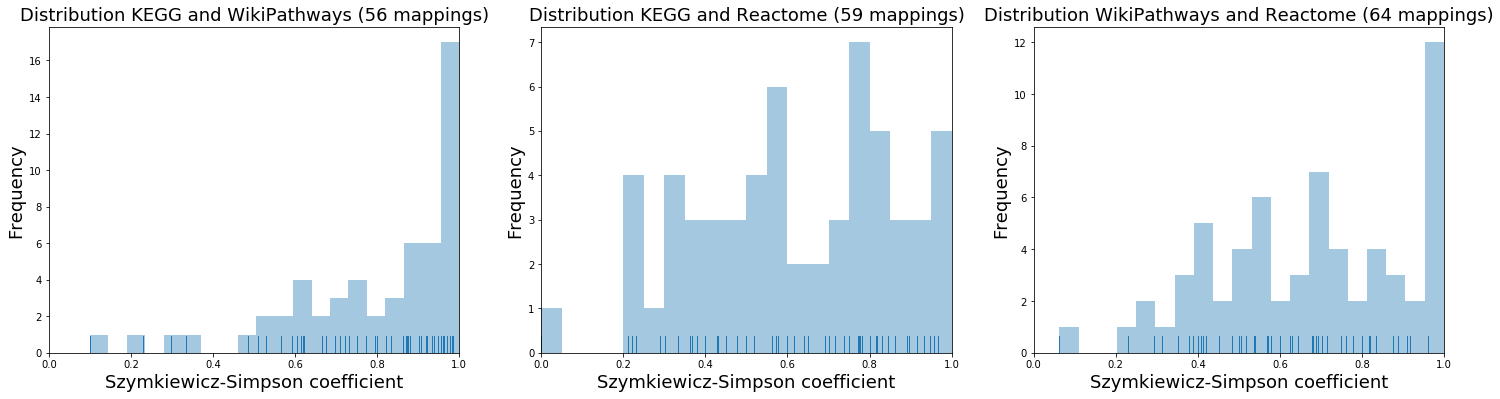

In [13]:
fig = plt.figure(figsize=(25, 6))

ax = fig.add_subplot(1, 3, 1)
ax.set_title('Distribution KEGG and WikiPathways ({} mappings)'.format(len(kegg_wikipathways_equivalent_overlaps)), fontsize=18)
ax.set_xlabel('Szymkiewicz-Simpson coefficient', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlim(0, 1)
sns.distplot(kegg_wikipathways_equivalent_overlaps, kde=False, rug=True,  bins=20)

ax = fig.add_subplot(1, 3, 2)
ax.set_title('Distribution KEGG and Reactome ({} mappings)'.format(len(kegg_reactome_equivalent_overlaps)), fontsize=18)
ax.set_xlabel('Szymkiewicz-Simpson coefficient', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlim(0, 1)
sns.distplot(kegg_reactome_equivalent_overlaps, kde=False, rug=True,  bins=20)

ax = fig.add_subplot(1, 3, 3)
ax.set_title('Distribution WikiPathways and Reactome ({} mappings)'.format(len(wikipathways_reactome_equivalent_overlaps)), fontsize=18)
ax.set_xlabel('Szymkiewicz-Simpson coefficient', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlim(0, 1)
sns.distplot(wikipathways_reactome_equivalent_overlaps, kde=False, rug=True,  bins=20)

plt.show()

The distributions present us with interesting results:

- The number of equivalent pathways between the three is fairly consistent (56, 58, and 64 shared pathtways).
- KEGG and WikiPathways share the highest similarity within the shared pathways (left-skewed distribution where the average is equals to 0.787 and the mode to 1). The reason for this might be related to the fact that Reactome granularity (smaller pathways in general, see plots at the bottom of the notebook) is different to KEGG and WikiPathways which contain mostly medium-sized pathways (~100 genes).
- Few pathways share a similarity lower than 0.4 (40% overlap).

_Note that there is one outlier in the left side of each histogram (equivalent pathways with less than 0.2 overlap)._

1. _In the first histogram (KEGG-WikiPathways): Steroid biosynthesis with 0.1 overlap (10%)_
2. _In the histogram on the middle (KEGG-Reactome): Linoleic acid metabolism does not share any gene with its the two pathways._
3. _In the last histogram (WikiPathways-Reactome): TGF-B Signaling in Thyroid Cells for Epithelial-Mesenchymal Transition with 0.0625 overlap._

It would be interesting to see what is the reason behind this low similarity between the equivalent pathways.

## Hierarchical pathways distribution based on similarity

In the following plots, we compare the similarity of pathways related by hierarhical mappings across the multiple pathway databases comparisons. The histogram plots the distribution of mappings (y axis) versus similarity (x axis). Similarity is calculated using the [Szymkiewicz–Simpson coefficient](https://en.wikipedia.org/wiki/Overlap_coefficient). The distributions show how most of the hierarchical mappings share high similarity based on content (distribution is assymetrical and right skewed). However, the number of mappings with low similarity is higher than the equivalent mappings.

In [8]:
print("############### KEGG vs WikiPathways #################\n")

kegg_wikipathways_is_part_of_overlaps, kegg_wikipathways_is_part_of_set , kegg_wikipathways_is_part_of_list = parse_is_part_of(
    kegg_wikipathways_df,
    kegg_manager,
    wikipathways_manager
)
      
print("{} isPartOf Overlaps. avg = {}\n".format(len(kegg_wikipathways_is_part_of_overlaps), np.mean(kegg_wikipathways_is_part_of_overlaps)))

print("############### KEGG vs Reactome #################\n")

kegg_reactome_is_part_of_overlaps, kegg_reactome_is_part_of_set , kegg_reactome_is_part_of_list = parse_is_part_of(
    kegg_reactome_df,
    kegg_manager,
    reactome_manager
)
      
print("{} isPartOf Overlaps. avg = {}\n".format(len(kegg_reactome_is_part_of_overlaps), np.mean(kegg_reactome_is_part_of_overlaps)))

print("############### WikiPathways vs Reactome #################\n")

wikipathways_reactome_is_part_of_overlaps, wikipathways_reactome_is_part_of_set , wikipathways_reactome_is_part_of_list = parse_is_part_of(
    wikipathways_reactome_df,
    wikipathways_manager,
    reactome_manager
)
      
print("{} isPartOf Overlaps. avg = {}\n".format(len(wikipathways_reactome_is_part_of_overlaps), np.mean(wikipathways_reactome_is_part_of_overlaps))) 

############### KEGG vs WikiPathways #################

247 isPartOf Overlaps. avg = 0.6089752808565702

############### KEGG vs Reactome #################

597 isPartOf Overlaps. avg = 0.6685498228518437

############### WikiPathways vs Reactome #################

564 isPartOf Overlaps. avg = 0.672734107485201



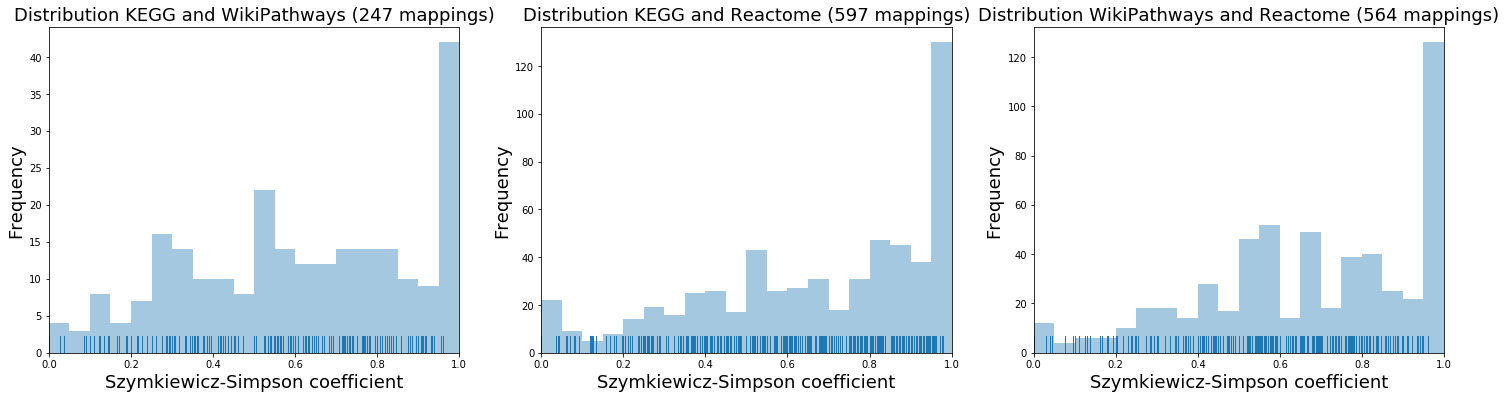

In [14]:
fig = plt.figure(figsize=(25, 6))

ax = fig.add_subplot(1, 3, 1)
ax.set_title('Distribution KEGG and WikiPathways ({} mappings)'.format(len(kegg_wikipathways_is_part_of_overlaps)), fontsize=18)
ax.set_xlabel('Szymkiewicz-Simpson coefficient', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlim(0, 1)
sns.distplot(kegg_wikipathways_is_part_of_overlaps, kde=False, rug=True, bins=20)

ax = fig.add_subplot(1, 3, 2)
ax.set_title('Distribution KEGG and Reactome ({} mappings)'.format(len(kegg_reactome_is_part_of_overlaps)), fontsize=18)
ax.set_xlabel('Szymkiewicz-Simpson coefficient', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlim(0, 1)
sns.distplot(kegg_reactome_is_part_of_overlaps, kde=False, rug=True, bins=20)

ax = fig.add_subplot(1, 3, 3)
ax.set_title('Distribution WikiPathways and Reactome ({} mappings)'.format(len(wikipathways_reactome_is_part_of_overlaps)), fontsize=18)
ax.set_xlabel('Szymkiewicz-Simpson coefficient', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlim(0, 1)
sns.distplot(wikipathways_reactome_is_part_of_overlaps, kde=False, rug=True, bins=20)

plt.show()


The distributions of hierarchical mappings are consistent across all inter-database mappings. As expected, hierarchical mappings share high similarity (peak of the distribution is located around 1.0). 

_It is important to mention that even more mappings are stored in the database thanks to the ComPath inference system. For example, when a KEGG/WikiPathways pathway is assigned as equivalent to a Reactome pathway, ComPath uses the Reactome hierarchy to infer new hierarchical mappings and map the super/sub pathways of the Reactome pathway to its corresponding KEGG/WikiPathways pathway. This plot is only for illustration purposes, because infered mappings were not included here. However, those mappings will no change the overall picture because they will share high similarity with the other pathway (since they are completely embedded in the other pathways)._

## Mapping Statistics

- | KEGG | Reactome | WikiPathways
---- |---- |----------|-------------
KEGG | - | 59 equivalentTo mappings / 597 isPartOf mappings | 56 equivalentTo mappings / 247 isPartOf mappings
Reactome | - | - | 64 equivalentTo mappings / 564 isPartOf mappings
WikiPathways | - | - | -

Table Summarizing the Mappings between Databases

### Extra: Distribution of pathway size for each database

In [10]:
kegg_distribution = kegg_manager.get_pathway_size_distribution()
reactome_distribution = reactome_manager.get_pathway_size_distribution()
wikipathways_distribution = wikipathways_manager.get_pathway_size_distribution()

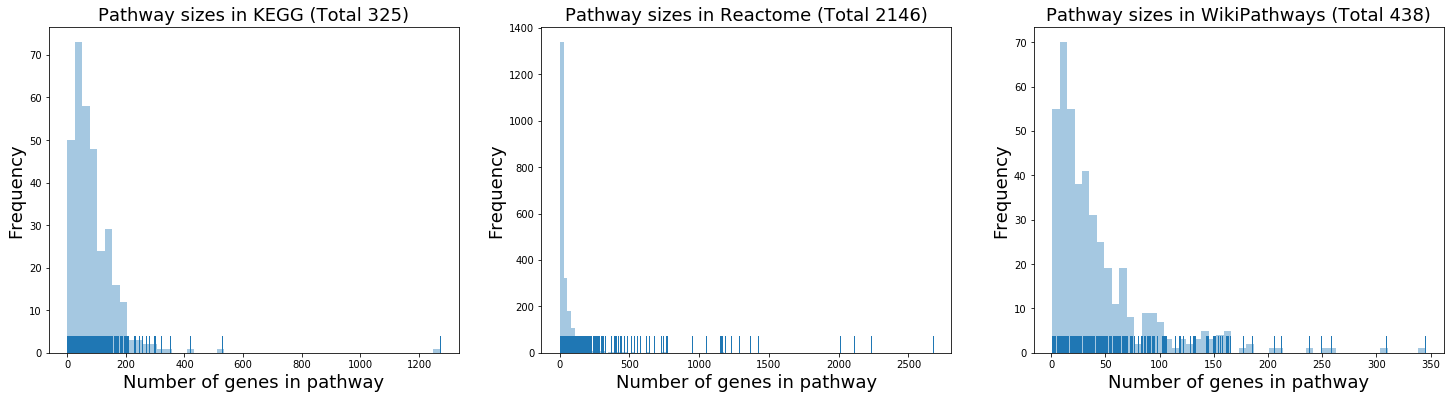

In [15]:
fig = plt.figure(figsize=(25, 6))

ax = fig.add_subplot(1, 3, 1)
ax.set_title('Pathway sizes in KEGG (Total {})'.format(len(kegg_distribution)), fontsize=18)
ax.set_xlabel('Number of genes in pathway', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
sns.distplot(list(kegg_distribution.values()), kde=False, rug=True, bins=50)

ax = fig.add_subplot(1, 3, 2)
ax.set_title('Pathway sizes in Reactome (Total {})'.format(len(reactome_distribution)), fontsize=18)
ax.set_xlabel('Number of genes in pathway', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
sns.distplot(list(reactome_distribution.values()), kde=False, rug=True, bins=100)

ax = fig.add_subplot(1, 3, 3)
ax.set_title('Pathway sizes in WikiPathways (Total {})'.format(len(wikipathways_distribution)), fontsize=18)
ax.set_xlabel('Number of genes in pathway', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
sns.distplot(list(wikipathways_distribution.values()), kde=False, rug=True, bins=50)

plt.show()

__Distribution of pathway size for each database__. Note that KEGG and WikiPathways present a similar pathway landscape, where most of the pathways with a range of 25-100 genes, in constrast to Reactome where most of the pathways contain less than 50 genes. The rationale for this is that Reactome pathways are more specific, and therefore smaller in size.